<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/notebooks/pyro_temporal_shift_ctf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

# Setup

In [1]:
! pip3 install pyro-ppl 
import pyro
import pyro.distributions as dist
pyro.set_rng_seed(101)


     |████████████████████████████████| 713 kB 8.7 MB/s 


In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import tensor, nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from sklearn.metrics import confusion_matrix

def doplt(arr_2d): return plt.imshow(arr_2d.detach().numpy(), cmap='gray')

In [7]:
!rm helper.py
!wget -O - https://raw.githubusercontent.com/geoffwoollard/physics_aware_cryoem/main/src/helper.py?token=ABFAXVBX6F7LCEULWLD26V3BYEK2M > helper.py
import helper
import importlib
importlib.reload(helper)
from helper import *

--2021-12-20 23:44:51--  https://raw.githubusercontent.com/geoffwoollard/physics_aware_cryoem/main/src/helper.py?token=ABFAXVBX6F7LCEULWLD26V3BYEK2M
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2074 (2.0K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   2.03K  --.-KB/s    in 0s      

2021-12-20 23:44:51 (22.2 MB/s) - written to stdout [2074/2074]



In [4]:
!cat helper.py

# atom blobs

In [28]:
torch.random.manual_seed(1)
num_pix=128
atom_centers_dist = dist.Uniform(low=-num_pix/4.,high=num_pix/4.)
num_atoms = 10
n_dim = 2
atom_centers_gt = torch.zeros(num_atoms,n_dim)
for idx_atoms in range(num_atoms):
  for idx_dim in range(n_dim):
    atom_centers_gt[idx_atoms,idx_dim] = atom_centers_dist.sample()
atom_centers_gt.shape

torch.Size([10, 2])

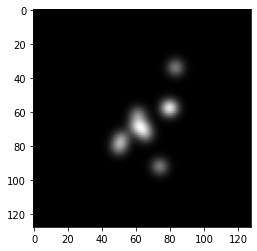

In [29]:

coords = make_coords(num_pix)
sigma_signal_gt = tensor(3.5)

clean_signal = make_clean_signal_multi_atom(atom_centers_gt,coords,sigma_signal_gt).reshape(num_pix,num_pix)
doplt(clean_signal)

# synthetic data

In [30]:
n_particles=5
n_time = 7

# shift
shift_loc_gt = tensor(0.)
shift_scale_gt = tensor(0.1)
shift_gt_dist = dist.Normal(shift_loc_gt,shift_scale_gt)
shift_gt = torch.zeros(2,n_time,n_particles)

# df
df_loc_gt = tensor(0.)
df_scale_gt = tensor(5.)
df_gt_dist = dist.Normal(df_loc_gt,df_scale_gt)
df_gt = torch.zeros(n_time,n_particles)

# shot noise
data = torch.zeros(num_pix,num_pix,n_time,n_particles)
sigma_noise=tensor([0.01]).cuda()

for idx_particle in range(n_particles):
  if n_particles < 10 or idx_particle % (n_particles//10) == 0: print('particle {}'.format(idx_particle))
  for idx_time in range(n_time):

    if idx_time == 0: 
      shift_x, shift_y = shift_gt_dist.sample().item(), shift_gt_dist.sample().item()
      df = df_gt_dist.sample() + tensor(100.)
    else:
      df = df_gt_dist.sample() + df
      shift_x = shift_gt_dist.sample().item() + shift_x
      shift_y = shift_gt_dist.sample().item() + shift_y
    shift = tensor([shift_x,shift_y]).reshape(1,2)

    # shift
    shift_gt[:,idx_time,idx_particle] = shift
    atom_centers_shift = (atom_centers_gt - shift).reshape(-1,2,1)

    # project    
    clean_signal = make_clean_signal_multi_atom_batch_cuda(atom_centers_shift.cuda(),coords.cuda(),sigma_signal_gt.reshape(1,).cuda()).reshape(num_pix,num_pix,-1)
    
    # ctf
    df_gt[idx_time,idx_particle] = df 
    clean_signal_f = do_fft_2d(clean_signal,dim=(0,1))
    ctf_2d = compute_ctf_2d_batch(df,num_pix)
    clean_signal_ctf = do_ifft_2d(clean_signal_f * ctf_2d.cuda(), dim=(0,1)).real
    
    # shot noise
    data[:,:,idx_time,idx_particle] = dist.Normal(clean_signal_ctf, sigma_noise).sample()[:,:,0]

particle 0
particle 1
particle 2
particle 3
particle 4


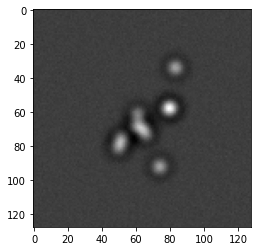

In [31]:
doplt(data[:,:,0,0])

## model

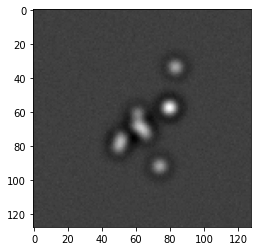

In [44]:
# net = CPN_CNN().cuda()
do_log=False

atom_centers_cuda = atom_centers_gt.reshape(-1,2,1).cuda()
coords_cuda = coords.cuda()
sigma_signal_gt_cuda = sigma_signal_gt.cuda()
atom_centers_gt_cuda = atom_centers_gt.cuda()

# # can precopute this part
# clean_signal = make_clean_signal_multi_atom_batch_cuda(atom_centers_cuda,coords_cuda,sigma_signal_gt_cuda.reshape(1,)).reshape(num_pix,num_pix,-1)
# clean_signal_f = do_fft_2d(clean_signal,dim=(0,1))

# shift
shift_scale_gt_cuda = shift_scale_gt.reshape(1,).cuda()

# df
df_loc_gt_cuda = df_loc_gt.cuda()
df_scale_gt_cuda = df_scale_gt.cuda()

sigma_noise_cuda = sigma_noise.cuda()


def model(mini_batch):
  """
  simulates a batch of particles, corresponding to observed 2d rotated particles
    no interpolation because analytical form of molecule potential used
  outputs result of forward model (just needs mini_batch tensor for shapes, data inside can be anything)
  """
  size_mini_batch = mini_batch.shape[-1]
  batch_idxs = torch.arange(size_mini_batch)
  size_time = mini_batch.shape[-2]
  if do_log: print('model mini_batch.shape',mini_batch.shape)
  sim_obs = torch.zeros(num_pix,num_pix,size_time,size_mini_batch)
  with pyro.plate('mini_batch',size_mini_batch):

    for idx_time in pyro.plate('time',size_time):
      if do_log: print('idx_time',idx_time)
      if idx_time == 0: 
        shift_loc_x = torch.zeros(size_mini_batch).cuda()
        shift_loc_y = torch.zeros(size_mini_batch).cuda()
        df_loc = (100.*torch.ones(size_mini_batch)).cuda()
      else:
        shift_loc_x = shift_x
        shift_loc_y = shift_y

      if do_log: print('shift_loc_x',shift_loc_x)
      shift_x = pyro.sample('shift_x_%d_'%idx_time, dist.Normal(shift_loc_x,shift_scale_gt_cuda))
      if do_log: print('shift_x',shift_x)
      shift_y = pyro.sample('shift_y_%d_'%idx_time, dist.Normal(shift_loc_y,shift_scale_gt_cuda))
      if do_log: print('shift_y',shift_y)
      df = pyro.sample('df_%d_', dist.Normal(df_loc,df_scale_gt_cuda))
      if do_log: print('df',df)
      shift = torch.hstack([shift_x,shift_y]).reshape(2,-1)
      if do_log: print('shift',shift)

      # shift
      atom_centers_shift = atom_centers_gt_cuda.reshape(-1,2,1) - shift.reshape(1,2,-1) # already on device
      if do_log: print('atom_centres_shift',atom_centers_shift)

      # project    
      if do_log: print('atom_centers_shift',atom_centers_shift[0,0,0])
      if do_log: print('coords_cuda',coords_cuda[0,0])
      if do_log: print('shift_scale_gt_cuda',shift_scale_gt_cuda)
      clean_signal = make_clean_signal_multi_atom_batch_cuda(atom_centers_shift,coords_cuda,sigma_signal_gt_cuda).reshape(num_pix,num_pix,-1)
      if do_log: print('clean_signal',clean_signal[0,0,0])
      
      # ctf
      ctf_2d = compute_ctf_2d_batch(df.cpu(),num_pix)
      if do_log: print('ctf_2d',ctf_2d[0,0,0])
      if do_log: print('ctf_2d.shape',ctf_2d.shape)
      clean_signal_f = do_fft_2d(clean_signal,dim=(0,1))
      clean_signal_ctf = do_ifft_2d(clean_signal_f * ctf_2d.cuda(), dim=(0,1)).real

      with pyro.plate('pixel_x',num_pix, dim=-3):
        with pyro.plate('pixel_y',num_pix, dim=-4):
          distrib = dist.Normal(clean_signal_ctf, sigma_noise)
          if do_log: print('distrib', distrib)
          for obs in [mini_batch.reshape(num_pix,num_pix,size_time,size_mini_batch)[:,:,idx_time,:], None]:
            if obs is None: 
              if do_log: print('obs None',obs) 
              sim = distrib.sample() # important not wrapped in pyro here, otherwise will reshape wrong (plates?)
              if do_log: print('sim.shape',sim.shape) 
              if do_log: print('sim_obs[:,:,idx_time,:].shape',sim_obs[:,:,idx_time,:].shape) 
              sim_obs[:,:,idx_time,:] =  sim 
            else:
              if do_log: print('obs.shape',obs.shape) 
              observe_with_data = pyro.sample("shot_noise", distrib, obs=obs)
              if do_log: print('observe_with_data.shape',observe_with_data.shape) 
    
    return sim_obs

sim_obs = model(mini_batch=0*data[:,:,:3,:5])

doplt(sim_obs[:,:,0,0])